# Prediction of Future Closing Stock Prices with Machine Learning v1.0

## Preliminaries: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta

## Part 1.1: Predict JFC stocks from 3/5/18 - 3/16/18 then compare with latest WSJ Data 

Since Google Finance data is not currently updated, we could get data from Wall Street Journal. Instead of using an API, we have to download csv files from the website.
Download csv file of JFC prices from 2013-1-1 to 2018-3-17.

Source: http://quotes.wsj.com/PH/XPHS/JFC/historical-prices

Import data.

In [2]:
stock = pd.read_csv('JFC_WSJ.csv')

Inspect dataframe.

In [3]:
stock.columns

Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')

## 1.2: Data Cleaning 

Remove spaces from column names by renaming them.

In [4]:
stock.rename(columns=lambda x: x.strip(), inplace=True)
stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 6 columns):
Date      1268 non-null object
Open      1268 non-null float64
High      1268 non-null float64
Low       1268 non-null float64
Close     1268 non-null float64
Volume    1268 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.5+ KB


In [6]:
stock.head()

Date   Open   High    Low  Close   Volume
0  03/16/18  286.8  305.4  286.8  305.4  2052470
1  03/15/18  288.4  288.6  282.6  284.0  1140780
2  03/14/18  293.0  294.4  287.4  288.4   757340
3  03/13/18  296.0  297.0  292.4  293.0   557650
4  03/12/18  296.0  299.0  292.2  295.4   303520

In [7]:
stock.tail()

Date   Open   High    Low  Close  Volume
1263  01/08/13  107.1  107.7  107.1  107.3  389530
1264  01/07/13  107.5  107.5  106.7  107.0  719780
1265  01/04/13  107.0  107.6  107.0  107.6  548040
1266  01/03/13  104.8  107.5  104.8  107.2  684290
1267  01/02/13  102.0  104.5  102.0  104.2  125900

In [8]:
stock.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No NaN values!!!
However, we have to rearrange the data from descending to ascending order.

In [9]:
stock = stock.reindex(index=stock.index[::-1]).reset_index(drop=True)

In [10]:
stock.head()

Date   Open   High    Low  Close  Volume
0  01/02/13  102.0  104.5  102.0  104.2  125900
1  01/03/13  104.8  107.5  104.8  107.2  684290
2  01/04/13  107.0  107.6  107.0  107.6  548040
3  01/07/13  107.5  107.5  106.7  107.0  719780
4  01/08/13  107.1  107.7  107.1  107.3  389530

In [11]:
stock.tail()

Date   Open   High    Low  Close   Volume
1263  03/12/18  296.0  299.0  292.2  295.4   303520
1264  03/13/18  296.0  297.0  292.4  293.0   557650
1265  03/14/18  293.0  294.4  287.4  288.4   757340
1266  03/15/18  288.4  288.6  282.6  284.0  1140780
1267  03/16/18  286.8  305.4  286.8  305.4  2052470

Convert 'Date' column as datetime objects and set it as index column.

In [12]:
stock['Date'] = pd.to_datetime(stock['Date'], infer_datetime_format=True)

In [13]:
stock.set_index('Date',inplace=True)

In [14]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1268 entries, 2013-01-02 to 2018-03-16
Data columns (total 5 columns):
Open      1268 non-null float64
High      1268 non-null float64
Low       1268 non-null float64
Close     1268 non-null float64
Volume    1268 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.4 KB


In [15]:
type(stock.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [16]:
stock.tail()

Open   High    Low  Close   Volume
Date                                           
2018-03-12  296.0  299.0  292.2  295.4   303520
2018-03-13  296.0  297.0  292.4  293.0   557650
2018-03-14  293.0  294.4  287.4  288.4   757340
2018-03-15  288.4  288.6  282.6  284.0  1140780
2018-03-16  286.8  305.4  286.8  305.4  2052470

Create Copy for exercise.

In [17]:
stockC = stock[stock.index.isin(pd.date_range(start='2013-01-01', end='2018-03-16'))]
stockC.tail(10)

Open   High    Low  Close   Volume
Date                                           
2018-03-05  299.0  300.0  296.0  299.6   388840
2018-03-06  300.0  304.0  297.8  298.6   833460
2018-03-07  300.0  304.0  299.8  304.0   853340
2018-03-08  303.0  304.0  295.0  295.0   367970
2018-03-09  297.0  297.0  292.0  292.0   352590
2018-03-12  296.0  299.0  292.2  295.4   303520
2018-03-13  296.0  297.0  292.4  293.0   557650
2018-03-14  293.0  294.4  287.4  288.4   757340
2018-03-15  288.4  288.6  282.6  284.0  1140780
2018-03-16  286.8  305.4  286.8  305.4  2052470

Notice that there are no values for 3/3 and 3/4. Trading days excluse weekends and holidays.

Add Prediction column which contains the predicted Close column value n trading days later.

The contents of the new column are just the values of the Close column shifted 5 days backwards, therefore, n=-5

In [18]:
n=-10
stockC['Prediction'] = stockC['Close'].shift(n)
stockC.tail(11)

Open   High    Low  Close   Volume  Prediction
Date                                                       
2018-03-02  297.6  298.4  295.0  298.0   735080       305.4
2018-03-05  299.0  300.0  296.0  299.6   388840         NaN
2018-03-06  300.0  304.0  297.8  298.6   833460         NaN
2018-03-07  300.0  304.0  299.8  304.0   853340         NaN
2018-03-08  303.0  304.0  295.0  295.0   367970         NaN
2018-03-09  297.0  297.0  292.0  292.0   352590         NaN
2018-03-12  296.0  299.0  292.2  295.4   303520         NaN
2018-03-13  296.0  297.0  292.4  293.0   557650         NaN
2018-03-14  293.0  294.4  287.4  288.4   757340         NaN
2018-03-15  288.4  288.6  282.6  284.0  1140780         NaN
2018-03-16  286.8  305.4  286.8  305.4  2052470         NaN

In [19]:
len(stockC)

1268

## 1.3: Preprocessing 

In order to prepare the data for machine learning, we have to delete all rows with NaN values.

In [20]:
from sklearn import preprocessing

In [21]:
X = preprocessing.scale(stockC.drop(['Prediction'], axis=1))

In [22]:
X_predict = X[n:]
X = X[:n]

In [23]:
y = stockC['Prediction'][:n]

In [24]:
print(type(X), type(X_predict), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [25]:
print(len(X), len(X_predict), len(y))

1258 10 1258


## 1.4: Train Test Split 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2))

In [28]:
print(type(X_train), type(X_test), type(y_train), type(y_test) )

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [29]:
print(len(X_train), len(X_test), len(y_train), len(y_test) )

1006 252 1006 252


## 1.5: Try with Linear Regression 

In [30]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 95.3162869564818%


## 1.6:  Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

lm = SVR(kernel='linear', C=1)
scores = cross_val_score(lm, X, y, cv=5)
scores #score for each split

array([0.90710032, 0.83853614, 0.45219766, 0.69773978, 0.86594637])

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.33)


## 1.7: Linear Regression after Cross Validation 

In [34]:
lm.fit(X_train, y_train)
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 95.27560741246856%


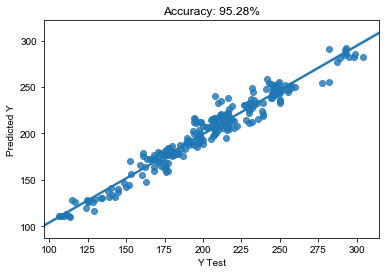

In [35]:
predictions = lm.predict(X_test)
sns.regplot(y_test,predictions)
plt.title('Accuracy: '+str((accuracy*100).round(2))+'%')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
sns.set_style('whitegrid')

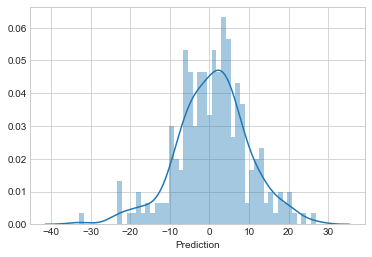

In [36]:
sns.distplot((y_test-predictions),bins=50)

## 1.8: Try with all regressors

C:\Users\LLagman\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


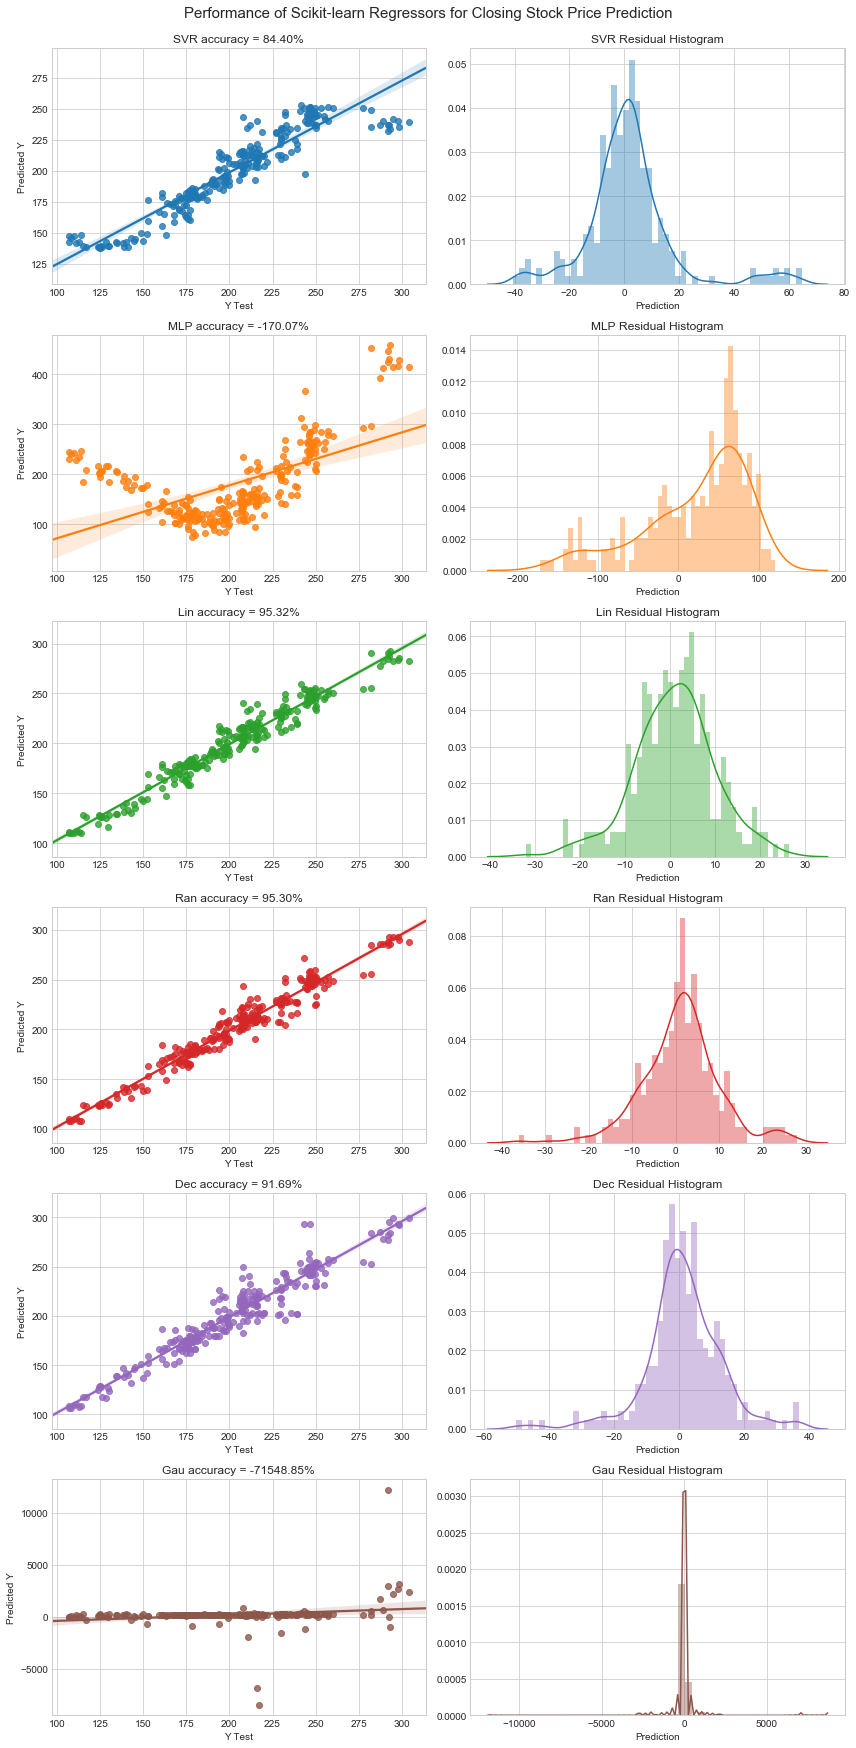

In [292]:
from sklearn import preprocessing#, cross_validation
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as NNR
from sklearn.linear_model import LinearRegression as LRR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

predictors = [SVR(), NNR(), LRR(), RFR(), DTR(), GPR()]

forecast = []
pred_cols = []
accuracy = []

fig, ax = plt.subplots(6,2, figsize=(12,24))

for pred, color, i in zip(predictors, sns.color_palette(), range(len(predictors))):
    pred.fit(X_train, y_train)
    accu = pred.score(X_test,y_test)
    predictions = pred.predict(X_test)
            
    sns.regplot(y_test,predictions, color=color, ax=ax[i,0])
    ax[i,0].set_title('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    ax[i,0].set_xlabel('Y Test')
    ax[i,0].set_ylabel('Predicted Y')
    
    sns.distplot((y_test-predictions), bins=50, color=color, ax=ax[i,1])
    ax[i,1].set_title('{0} Residual Histogram'.format(str(pred)[:3]))
    
    forecast.append(pred.predict(X_predict))
    pred_cols.append(str(pred)[:3])
    accuracy.append('{0} accuracy = {1:.2f}'.format(str(pred)[:3], (accu*100).round(2))+'%')
    
fig.suptitle('Performance of Scikit-learn Regressors for Closing Stock Price Prediction', fontsize=15, y=1.01)
sns.set_style('whitegrid')
fig.tight_layout()

##  1.9: Add forecast columns per regressor

Forecast: Data for columns

In [280]:
np.array(forecast).shape

(6, 10)

In [281]:
np.array(forecast)

array([[   226.01784172,    227.7414027 ,    225.99687935,
           225.06022657,    228.91085182,    227.14839184,
           231.69607479,    236.38460345,    237.99004423,
           210.76943392],
       [   472.97758918,    485.96174667,    494.15145315,
           475.05272363,    454.77491034,    458.88151304,
           458.22956952,    445.26886396,    430.95763641,
           489.43824112],
       [   297.06595424,    299.37263785,    301.97581741,
           295.97949397,    292.20465105,    293.62140025,
           293.11950619,    289.22685257,    285.21765399,
           298.89585502],
       [   285.96      ,    296.14      ,    291.36      ,
           279.44      ,    279.44      ,    279.44      ,
           290.02      ,    285.56      ,    281.04      ,
           284.98      ],
       [   305.4       ,    305.4       ,    305.4       ,
           285.        ,    285.        ,    285.        ,
           284.        ,    283.        ,    282.        ,
           

In [282]:
forecast_T = np.array(forecast).transpose()
forecast_T

array([[   226.01784172,    472.97758918,    297.06595424,
           285.96      ,    305.4       ,   1858.63956451],
       [   227.7414027 ,    485.96174667,    299.37263785,
           296.14      ,    305.4       ,  -6557.75816393],
       [   225.99687935,    494.15145315,    301.97581741,
           291.36      ,    305.4       , -12409.64265347],
       [   225.06022657,    475.05272363,    295.97949397,
           279.44      ,    285.        ,   -586.26800823],
       [   228.91085182,    454.77491034,    292.20465105,
           279.44      ,    285.        ,   4064.36097431],
       [   227.14839184,    458.88151304,    293.62140025,
           279.44      ,    285.        ,   1133.70153522],
       [   231.69607479,    458.22956952,    293.11950619,
           290.02      ,    284.        ,   2871.00636673],
       [   236.38460345,    445.26886396,    289.22685257,
           285.56      ,    283.        ,   1453.19325066],
       [   237.99004423,    430.95763641,    285

Days: Index

In [283]:
len(stockC.index)

1268

In [284]:
stockC.index[-1]

Timestamp('2018-03-16 00:00:00')

In [285]:
Days=stockC.index[n:len(stockC.index)]
Days

DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

Accuracy: column names

In [296]:
type(accuracy)

list

In [297]:
accuracy

['SVR accuracy = 84.40%',
 'MLP accuracy = -170.07%',
 'Lin accuracy = 95.32%',
 'Ran accuracy = 95.30%',
 'Dec accuracy = 91.69%',
 'Gau accuracy = -71548.85%']

In [298]:
regs_stockC = pd.DataFrame(data=forecast_T,
                    index=stockC.index[n:len(stockC.index)],
                    columns=accuracy)
regs_stockC

SVR accuracy = 84.40%  MLP accuracy = -170.07%  \
Date                                                         
2018-03-05             226.017842               472.977589   
2018-03-06             227.741403               485.961747   
2018-03-07             225.996879               494.151453   
2018-03-08             225.060227               475.052724   
2018-03-09             228.910852               454.774910   
2018-03-12             227.148392               458.881513   
2018-03-13             231.696075               458.229570   
2018-03-14             236.384603               445.268864   
2018-03-15             237.990044               430.957636   
2018-03-16             210.769434               489.438241   

            Lin accuracy = 95.32%  Ran accuracy = 95.30%  \
Date                                                       
2018-03-05             297.065954                 285.96   
2018-03-06             299.372638                 296.14   
2018-03-07             301.975817                 291.36   
2018-03-08             295.979494                 279.44   
2018-03-09             292.204651                 279.44   
2018-03-12             293.621400                 279.44   
2018-03-13             293.119506                 290.02   
2018-03-14             289.226853                 285.56   
2018-03-15             285.217654                 281.04   
2018-03-16             298.895855                 284.98   

            Dec accuracy = 91.69%  Gau accuracy = -71548.85%  
Date                                                          
2018-03-05                  305.4                1858.639565  
2018-03-06                  305.4               -6557.758164  
2018-03-07                  305.4              -12409.642653  
2018-03-08                  285.0                -586.268008  
2018-03-09                  285.0                4064.360974  
2018-03-12                  285.0                1133.701535  
2018-03-13                  284.0                2871.006367  
2018-03-14                  283.0                1453.193251  
2018-03-15                  282.0                3677.750919  
2018-03-16                  297.6                7658.518732

In [299]:
accuracy

['SVR accuracy = 84.40%',
 'MLP accuracy = -170.07%',
 'Lin accuracy = 95.32%',
 'Ran accuracy = 95.30%',
 'Dec accuracy = 91.69%',
 'Gau accuracy = -71548.85%']

## 1.9.1: Plot all Regressor Predictions 

In [303]:
label='JFC.PH'

Text(0,0.5,'Closing Price (₱)\n')

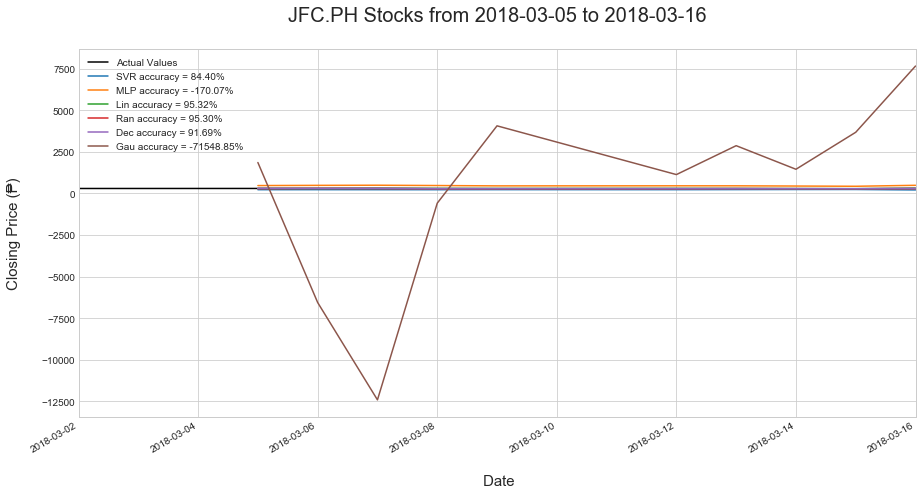

In [326]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(15,7.5))
regs_stockC.plot(color=sns.color_palette(), ax=ax)

plt.title('{0} Stocks from {1} to {2}\n'.format(label,str(days[0])[0:10],str(days[-1])[0:10]), fontsize=20)
plt.legend(loc='best')
plt.xlim(xmin=stockC.index[-11],xmax=days[-1])
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

Text(0,0.5,'Closing Price (₱)\n')

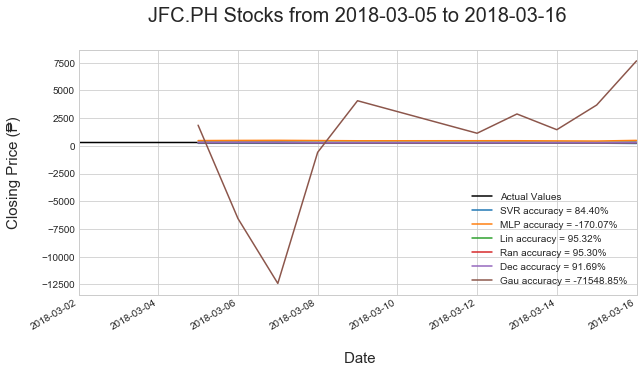

In [332]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(10,5))
regs_stockC.plot(color=sns.color_palette(), ax=ax)

plt.title('{0} Stocks from {1} to {2}\n'.format(label,str(days[0])[0:10],str(days[-1])[0:10]), fontsize=20)
plt.legend(loc='best')
plt.xlim(xmin=stockC.index[-11],xmax=days[-1])
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

Plot every column in regs_stockC except for MLP and Gau

In [368]:
regs_stockC.columns[0]

'SVR accuracy = 84.40%'

In [369]:
[regs_stockC.columns[0]]

['SVR accuracy = 84.40%']

In [370]:
regs_stockC.columns[2:5]

Index(['Lin accuracy = 95.32%', 'Ran accuracy = 95.30%',
       'Dec accuracy = 91.69%'],
      dtype='object')

In [371]:
regs_stockC.columns[2:5].tolist()

['Lin accuracy = 95.32%', 'Ran accuracy = 95.30%', 'Dec accuracy = 91.69%']

In [367]:
[regs_stockC.columns[0]]+regs_stockC.columns[2:5].tolist()

['SVR accuracy = 84.40%',
 'Lin accuracy = 95.32%',
 'Ran accuracy = 95.30%',
 'Dec accuracy = 91.69%']

In [379]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [380]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [382]:
[sns.color_palette()[0]]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

In [381]:
sns.color_palette()[2:5]

[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [385]:
[sns.color_palette()[0]]+sns.color_palette()[2:5]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

Text(0,0.5,'Closing Price (₱)\n')

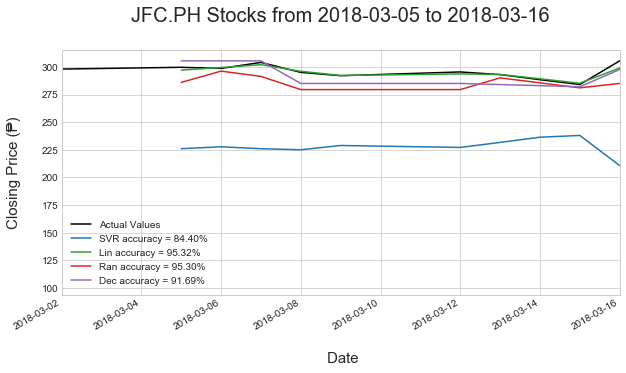

In [386]:
ax = stockC['Close'].plot(color='black', label='Actual Values', figsize=(10,5))
regs_stockC[[regs_stockC.columns[0]]+regs_stockC.columns[2:5].tolist()].plot(
    color=[sns.color_palette()[0]]+sns.color_palette()[2:5], ax=ax)

plt.title('{0} Stocks from {1} to {2}\n'.format(label,str(days[0])[0:10],str(days[-1])[0:10]), fontsize=20)
plt.legend(loc='best')
plt.xlim(xmin=stockC.index[-11],xmax=days[-1])
plt.xlabel('\n Date', fontsize=15)
plt.ylabel('Closing Price (₱)\n', fontsize=15) 

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import cufflinks as cf

In [ ]:
init_notebook_mode(connected=True)

In [ ]:
cf.go_offline()

In [329]:
"""rows = {str(pred_g)[:3]:forecast.tolist()}
rows"""

'rows = {str(pred_g)[:3]:forecast.tolist()}\nrows'

In [348]:
forecast

array([305.4, 305.4, 305.4, 292. , 292. , 292. , 292. , 282. , 282. ,
       282. ])

In [330]:
type(cols)

list

In [331]:
cols

[]

In [332]:
np.array(forecast).shape

(4, 10)

In [333]:
forecast

[array([227.83056762, 229.30430783, 227.51323159, 226.8587786 ,
        230.78851693, 229.02509855, 233.49823185, 238.09193123,
        239.41401499, 211.58334309]),
 array([297.162792  , 299.51974753, 302.59817128, 295.00524659,
        291.78428903, 293.66865491, 292.95848926, 288.62772513,
        284.39843121, 300.12888505]),
 array([294.78, 296.86, 296.86, 294.78, 292.44, 294.78, 292.8 , 284.1 ,
        282.1 , 287.28]),
 array([305.4, 305.4, 305.4, 293. , 292. , 293. , 292. , 282. , 282. ,
        292. ])]

In [334]:
days

DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [335]:
np.array(days).shape

(10,)